In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import sklearn.metrics as sm

base_path = '/home/maj/data/insideairbnb/processed/'
train = pd.read_csv(base_path + 'train.csv', low_memory=False)
validate = pd.read_csv(base_path + 'validate.csv', low_memory=False)
test = pd.read_csv(base_path + 'test.csv', low_memory=False)
train_validate = pd.concat([train, validate], keys=['train', 'val'])
train_validate.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,...,house_rules_p,review_len,review_spec,review_num,svd_R,review_p,review_s,if_monthly,distance_min,price_log
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.432058,0.000776,0.997301,0.457991,0.001416,0.003226,-0.000436,0.000838,0.004530,0.546703,...,0.000111,-0.000343,-0.006913,-0.004571,0.005599,0.002076,0.001881,-0.007906,-0.003711,4.855212
std,0.495391,0.999817,0.051884,0.498261,1.001676,1.003955,1.013899,1.005067,0.982705,0.497843,...,1.000088,0.993335,0.956155,0.990426,0.992535,0.993063,0.992220,0.986144,0.999398,0.698210
min,0.000000,-0.243628,0.000000,0.000000,-1.435661,-1.621742,-0.246156,-0.634275,-12.209914,0.000000,...,-6.169202,-2.179418,-1.110441,-0.884758,-6.420100,-8.742889,-5.402021,-0.266410,-1.065591,2.302585
25%,0.000000,-0.238199,1.000000,0.000000,-0.937338,-0.481991,-0.246156,-0.590649,-0.080458,0.000000,...,-0.527809,-0.495224,-0.254877,-0.489322,-0.317731,-0.263927,-0.196427,-0.266410,-0.557558,4.369448
50%,0.000000,-0.232771,1.000000,0.000000,0.059306,-0.481991,-0.182337,-0.401604,0.242994,1.000000,...,-0.527809,0.004908,-0.142047,-0.108233,0.009905,-0.000321,0.029038,-0.266410,-0.323735,4.828314
75%,1.000000,-0.194770,1.000000,1.000000,1.055951,0.657761,-0.118518,0.150989,0.566446,1.000000,...,0.405026,0.297912,-0.011113,0.135818,0.502167,0.372443,0.394104,-0.266410,0.122526,5.298317
max,1.000000,9.636534,1.000000,1.000000,2.052595,4.077015,50.745168,11.275558,0.728172,1.000000,...,6.523932,18.193288,28.370835,19.118522,4.899802,5.618845,4.126983,3.753609,6.003178,6.906755


In [2]:
# TODO is this required?  Many vars already centered/scaled
scaler = StandardScaler()
train_validate_X = scaler.fit_transform(train_validate.drop('price_log', axis=1).to_numpy())

In [3]:
%%time
grid_result = GridSearchCV(estimator=KNeighborsRegressor(algorithm='brute'),
                    param_grid=dict(n_neighbors=list(range(1,40)),
                                    p=[1, 2]),
                    cv=[(train_validate.index.get_locs(['train']), train_validate.index.get_locs(['val']))],
                    n_jobs=20).fit(train_validate_X, train_validate.price_log.to_numpy())
grid_result.best_params_

CPU times: user 471 ms, sys: 241 ms, total: 712 ms
Wall time: 12.3 s


{'n_neighbors': 10, 'p': 1}

In [4]:
tX_test = scaler.transform(test.drop('price_log', axis=1).to_numpy())
grid_result.best_estimator_.score(X_test, test.price_log.to_numpy())

0.6567808171315166

In [5]:
sm.mean_squared_error(test.price_log.to_numpy(),
                      grid_result.best_estimator_.predict(X_test).flatten())

0.15772642526361522

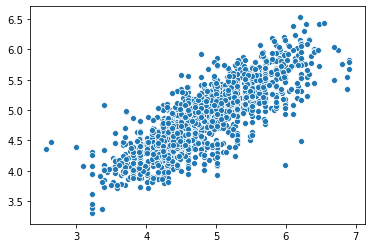

In [6]:
sns.scatterplot(test.price_log.to_numpy(),
                grid_result.best_estimator_.predict(X_test).flatten())

In [7]:
# TODO persist the models and scaling
# https://scikit-learn.org/stable/modules/model_persistence.html